In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from results import *
from evaluate import *

sns.set_style("darkgrid")
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]
CMAP = sns.color_palette(flatui)
FIGSIZE = (13, 8)
POINT_SIZE = 60

Load the result json files into a custom class that gives easy access to evaluation metrics.

In [38]:
results = [Result.from_json(p) for p in Path("../analysis/").rglob("*evaluation/results.json")]

Turn results into a dataframe for plotting

In [3]:
results_dicts = [r.as_dict() for r in results]
results_df = pd.DataFrame(results_dicts)

In [4]:
results_df

,conf_threshold,coverage,denovo_kmer_size,denovo_precision,denovo_recall,max_nesting,num_snps,overall_accuracy,overall_error_rate,overall_precision,overall_recall,read_quality
0,0,100,9,1.179148,0.8030,3,1000,0.762319,0.237681,0.957524,0.7890,imperfect
1,0,100,11,1.140770,0.8590,3,1000,0.809384,0.190616,0.972973,0.8280,imperfect
2,0,100,13,1.089024,0.8930,3,1000,0.842675,0.157325,0.980549,0.8570,imperfect
3,0,60,9,1.155488,0.7580,3,1000,0.707177,0.292823,0.942602,0.7390,imperfect
4,0,60,11,1.124650,0.8030,3,1000,0.744908,0.255092,0.961202,0.7680,imperfect
5,0,60,13,1.072152,0.8470,3,1000,0.789834,0.210166,0.972323,0.8080,imperfect
6,0,15,9,0.777778,0.2730,3,1000,0.236444,0.763556,0.680307,0.2660,imperfect
7,0,15,11,0.756032,0.2820,3,1000,0.242049,0.757951,0.674877,0.2740,imperfect
8,0,15,13,0.729730,0.2970,3,1000,0.258237,0.741763,0.702179,0.2900,imperfect
9,0,30,9,1.065476,0.5370,3,1000,0.487109,0.512891,0.860163,0.5290,imperfect


# Metric definitions
The first thing we need to do is define some terminology that will be used for this analysis.

## True Positive (TP)
### Correct variant allele or position call
This is defined as an entry in `pandora`'s VCF which, when taken with flanking sequence, maps over a variant position in the reference panel and has the **correct** base call at the expected position. *Note:* Mismatches are allowed in the flanks.

## False Positive (FP)
### Incorrect variant allele or position call
This is defined as an entry in `pandora`'s VCF which, when taken with flanking sequence, maps over a variant position in the reference panel and has the **incorrect** base call at the expected position. *Note:* Mismatches are allowed in the flanks.

## False Negative (FN)
### Incorrect reference genotype or no call
This is defined as an entry in the reference panel which does not have any variants from `pandora`'s VCF that map across its variant position.  
*Note:* a `pandora` variant call can map to an entry in the reference panel but may not map across the middle position (which is the variant position).

## True Negative (TN)
### Correct reference genotype or no call
This is basically any position we have left the same as the reference correctly. True negatives would only really be relevant if we decided to apply the variant calls from `pandora` onto the consensus sequence from `pandora` and do a base-by-base comparison of that to the reference sequence.  
We will not consider TNs for the remainder of this analysis.

## Accuracy
### Ratio of correct calls to total calls and variants
**Calculation:** TP+~~TN~~/TP+FP+~~TN~~+FN  


## Specificity
### Non-variants not called as variants relative to the total non-variants
**Calculation:** TN/TN+FP

Not being used in this analysis due to the reliance on TNs.

## Sensitivity / Recall
### True variants called relative to all variants
**Calculation:** TP/TP+FN  


## Precision 
### True variants called relative to total calls 
**Calculation:** TP/TP+FP  


## False positive rate
### Non-variants called relative to the total non-variants
**Calculation:** FP/TN+FP  

Not being used in this analysis due to the reliance on TNs.

# Analysis
This analysis is looking at the results from running the simulations on 50 genes with varying parameters. The aim is decide on which parameter defaults should be used for running the simulations on a much larger sample of genes.  

To begin with, let's plot the precision (y) and recall (x) but focusing purely on the candidate paths produced by *de novo* discovery. In this context, recall is defined as the percentage of simulated mutations where the mutant allele was included amongst the *de novo* slices. Precision is thus defined as the percentage of *de novo* slices that include a variant from the reference panel.  
For the plotting, we will colour (hue) the plot by the read quality. That is, were the simulated reads perfect (no errors) or imperfect (error profile from ONT R9 *E. coli* data).

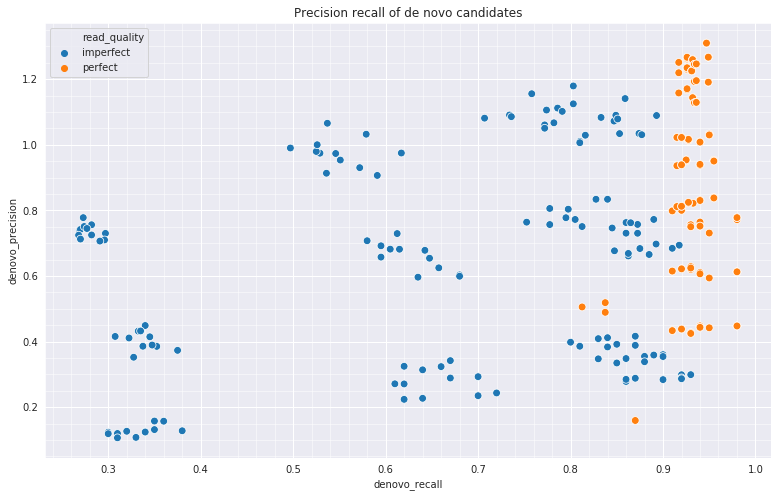

In [5]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=results_df, 
                       ax=ax,  
                       hue="read_quality", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

Next, lets look at a precision recall plot again, but this time using the entries in the VCF produced by `pandora`.

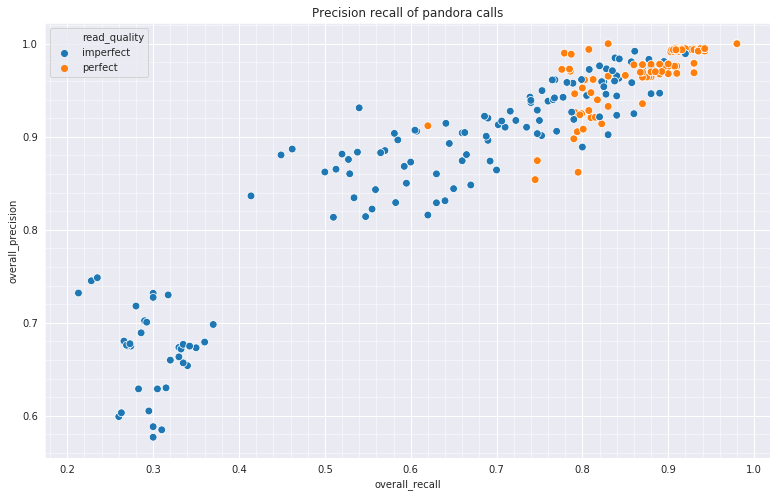

In [6]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=results_df, 
                       ax=ax,  
                       hue="read_quality", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

From both of these plots it is fairly clear that read quality makes a very big difference to the precision-recall relationship. As such, we can partition the data into perfect and imperfect sets to dig in to more detail about how the other parameters effect this relationship.

In [7]:
imperfect_df = results_df.drop(results_df[results_df.read_quality == "perfect"].index)
perfect_df = results_df.drop(results_df[results_df.read_quality == "imperfect"].index)

## Effect of coverage
Let's first take a look at how coverage effects the precision-recall relationship.

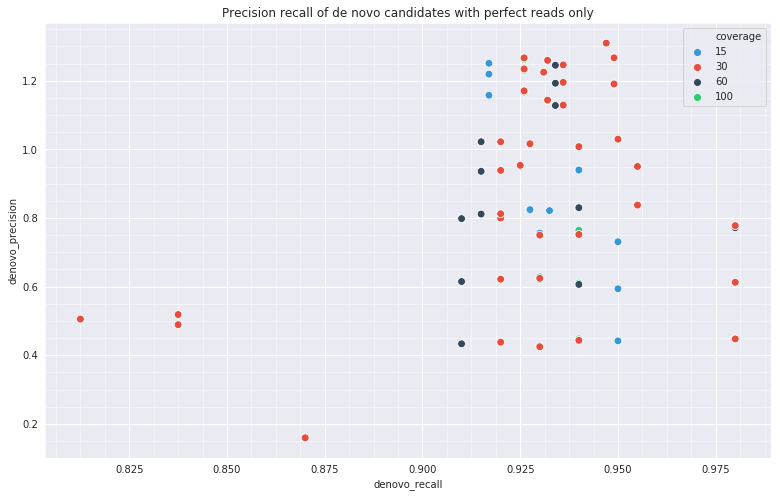

In [8]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP, 
                       hue="coverage", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

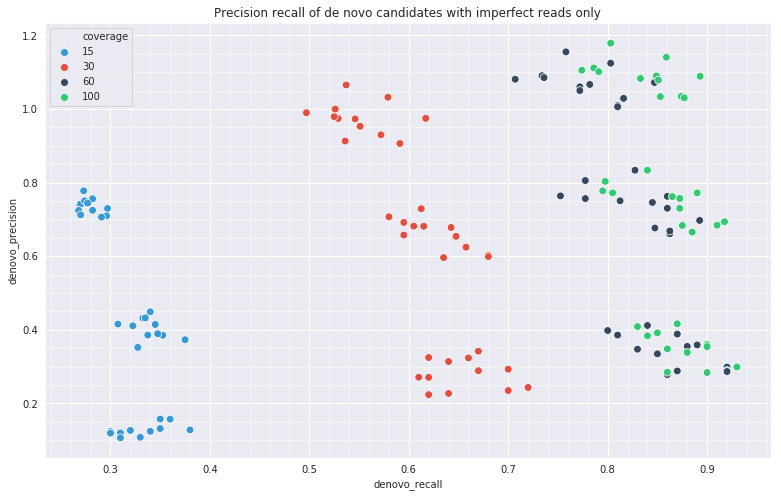

In [9]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP, 
                       hue="coverage", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

These two plots show an interesting difference. For the perfect reads, there does not seem to be a requirement for any particular level of coverage, suggesting that for perfect reads, other parameters likely explain the variation. But for the imperfect reads it is very obvious that as you increase coverage, the number of variants you are able to discover increases also.  

From this we can also say that, in the best case, for imperfect reads with 100x coverage we are able to correctly discover ~77% of variants and that ~95% of the *de novo* slices contain a variant.  
For perfect reads, we can also say that, in the best case, we are able to correctly discover about 84% of variants and that ~98% of the *de novo* slices contain a variant. Additionally, coverage doesn't seem to play too big a role in this relationship, although it should be noted that, oddly, 60x coverage doesn't have as good results as the other coverage levels.  

*Note:* For these plot, precision actually goes above 1.0. The reason for this is that in some cases we find multiple variants in the one *de novo* slice.

And now looking at the same thing from the VCF output of `pandora`

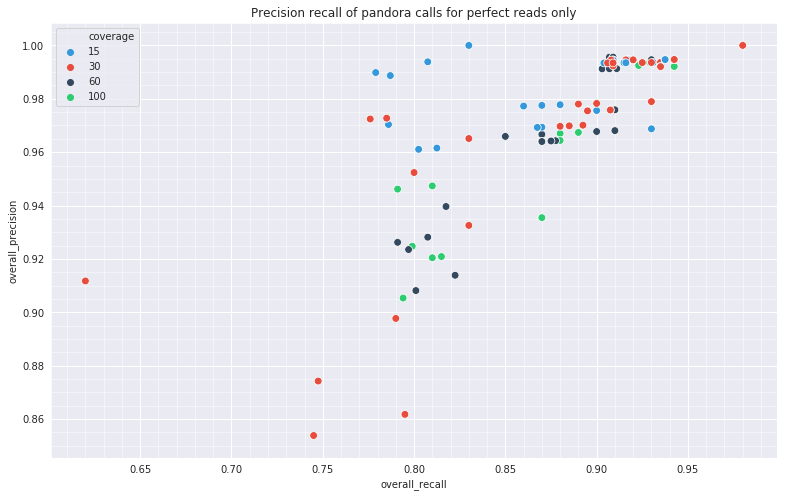

In [10]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="coverage", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

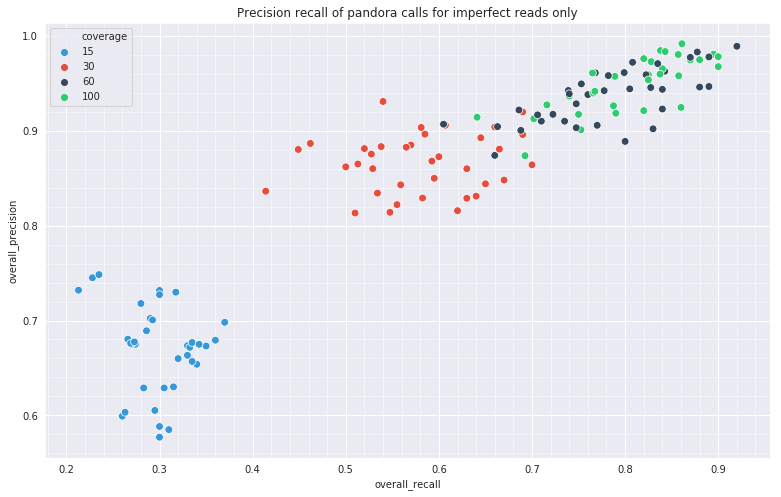

In [11]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="coverage", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

For the `pandora` calls we see a very similar relationship as before: coverage doesn't effect the precision-recall relationship for perfect reads, but absolutelty does for imperfect reads.  

From this we can also say that, in the best case, for imperfect reads with $\geq$60x coverage ~90% of calls are correct (precision) and ~90% of the variants were, correctly, called (recall).
For perfect reads, we can also say that, in the best case, ~91% of calls are correct (precision) and ~92% of the variants were, correctly, called (recall). Additionally, coverage doesn't seem to play too big a role in this relationship, although it should be noted that, oddly, 60x coverage doesn't have as good results as the other coverage levels.

## Effect of maximum nesting level
When building the PRG one of the setting which can altered is the maximum level of nesting allowed in your graph. Here we assess how this parameter impacts the precision-recall relationship.

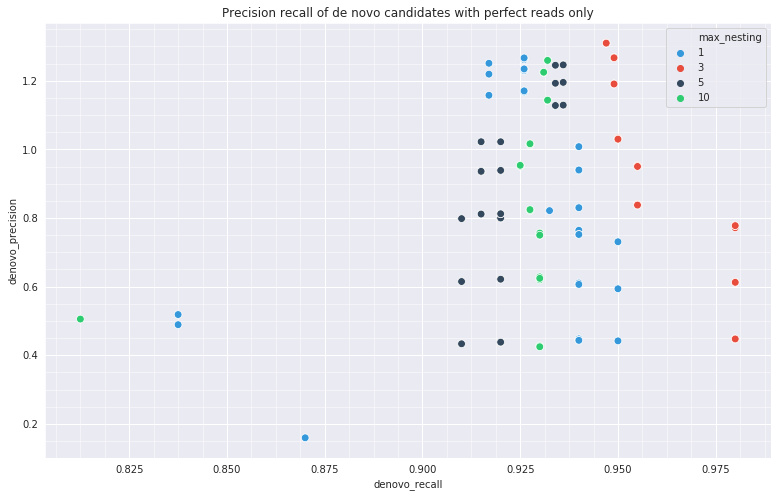

In [12]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP, 
                       hue="max_nesting", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

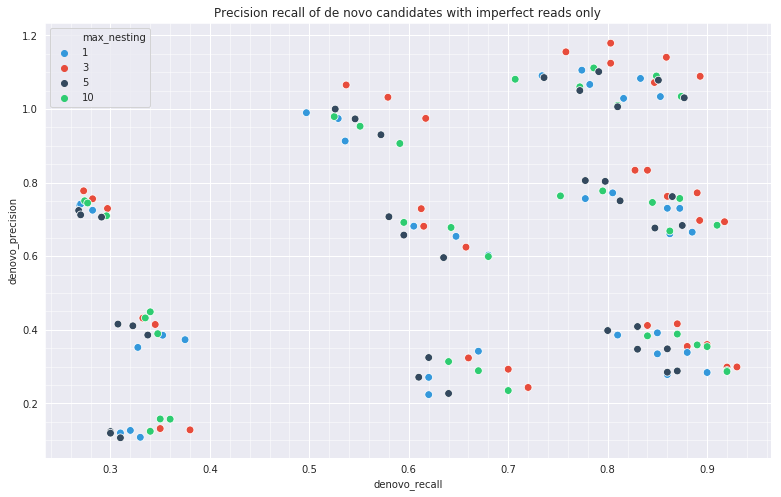

In [13]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP, 
                       hue="max_nesting", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

When looking at the candidate paths produced by *de novo* the maximum PRG nesting level doesn't appear to have a dramatic effect on the precision recall relationship.  
One thing that is consistent for imperfect reads is probably that a maximum nesting level of 3 seems to produce worse results and for perfect reads a level of 10 produces the worst results.  

In summary, the discover of variants doesn't seem to depend too much on the maximum nesting level, although a value of 5 might be slightly beneficial.

And now looking at the same thing from the VCF output of `pandora`

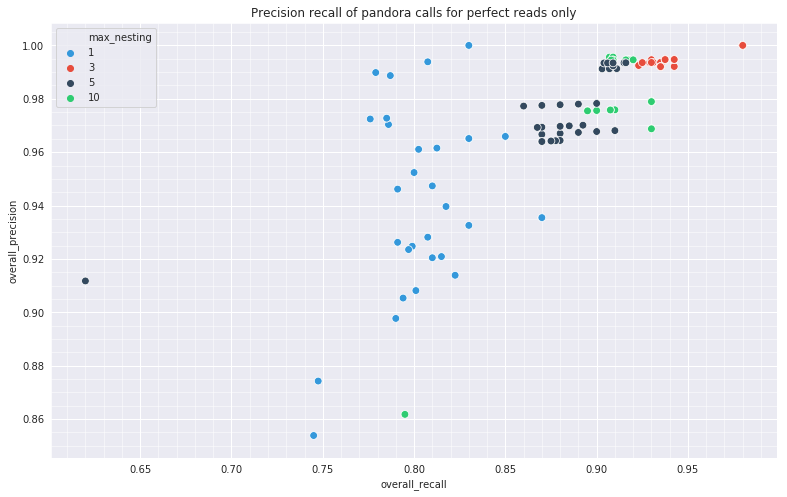

In [14]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="max_nesting", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

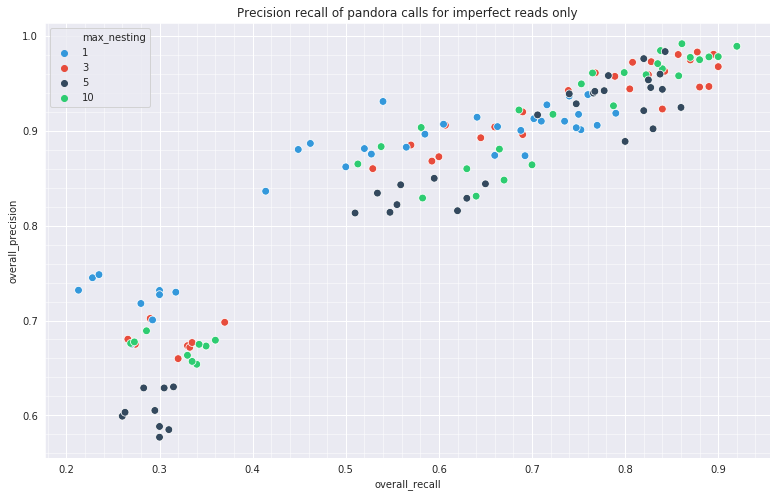

In [15]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="max_nesting", 
#                        style="coverage",
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

It appears as though a maximum nesting level of 3 or 5 tends to be more commonly in the top right quadrant for imperfect reads.

In summary, the discover of variants doesn't seem to depend too much on the maximum nesting level, although a value of 3 or 5 might be slightly beneficial. **We would advocate the use of 5 as a default**.

## Effect of the number of SNPs
Bacterial species vary in their mutation rate and therefore we thought it would be useful to assess whether more or less SNPs per gene effects `pandora`'s ability to discover *de novo* mutations.  

*Note:* the number of SNPs in the plots is the number of SNPs per gene multiplied by the number of genes in total (50 in this case).

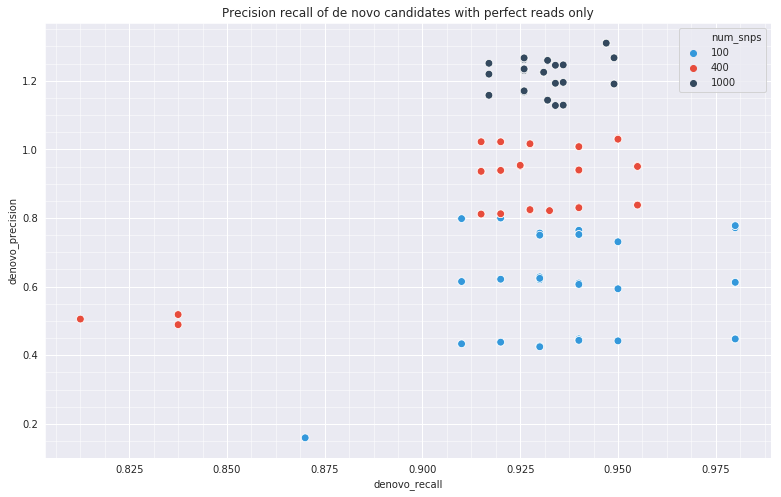

In [16]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP[:-1], 
                       hue="num_snps", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

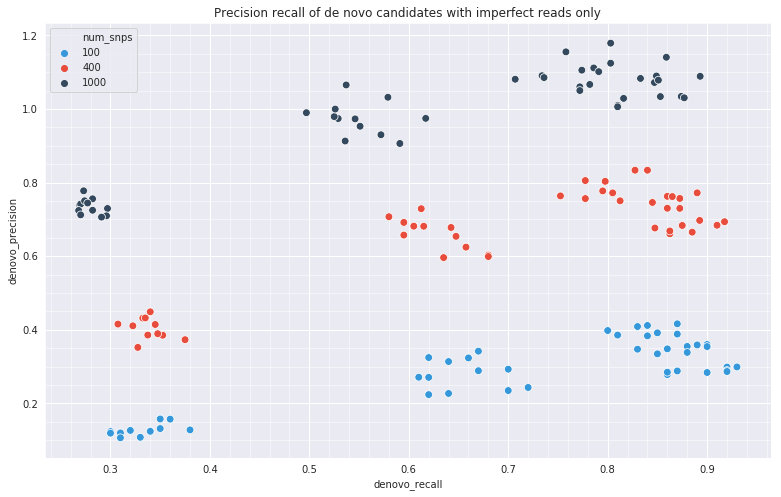

In [17]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=imperfect_df, 
                       ax=ax,
                       palette=CMAP[:-1], 
                       hue="num_snps", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

The relationship for the perfect reads can be summed up as the less SNPs per gene there is, the less candidate slices that contain a variant. Interestingly, 3 and 5 SNPs per gene fall around 100% of slices containing variants (precision). Once you get to 10 SNPs per gene the precision moves over 100%, meaning multiple SNPs are being found in the same slice. For the 1 SNP per gene we are finding 50-80% of slices contain a variant. This is probably a fairly expected relationship; the more SNPs there are, the more likely it is that a slice will contain a SNP. For the perfect reads it appears that the number of SNPs per gene has no effect on the recall.  

For the imperfect reads we see very much the same relationship as the perfect reads: precision increases with increasing number of SNPs per gene, however, the differences are more pronounced. We see that, at best, for the 1 SNP per gene samples we have ~55% of slices containing a variant, meaning we are running *de novo* discovery twice for every variant we find. In the average case for the 10 SNPs per gene samples, we get a variant every time we run *de novo* discovery. Again, the recall, i.e the percentage of variants we discover, does not seem to be exerting any effect on the number of SNPs, but you can very clearly see the impact that coverage has here. Each colour in the plot has a very distinct second-order polynomial relationship and if you lay coverage information over this you can see this relationship is defined purely by the amount of coverage (see below).

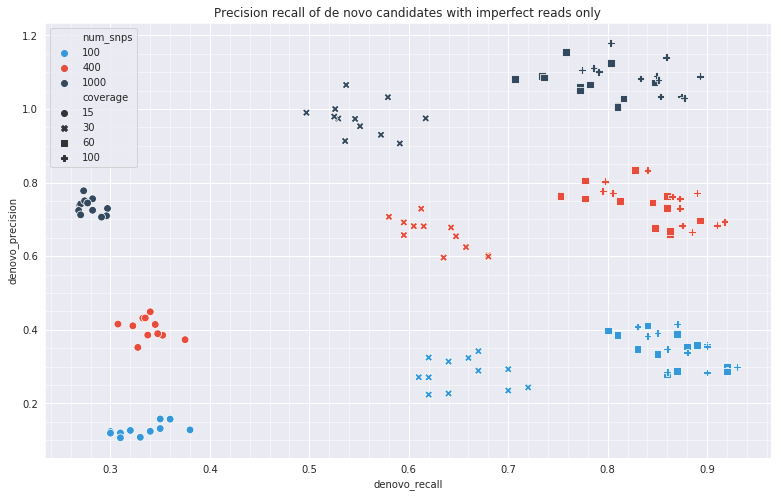

In [18]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=imperfect_df, 
                       ax=ax,
                       style="coverage",
                       palette=CMAP[:-1], 
                       hue="num_snps", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

And now looking at the same thing from the VCF output of `pandora`

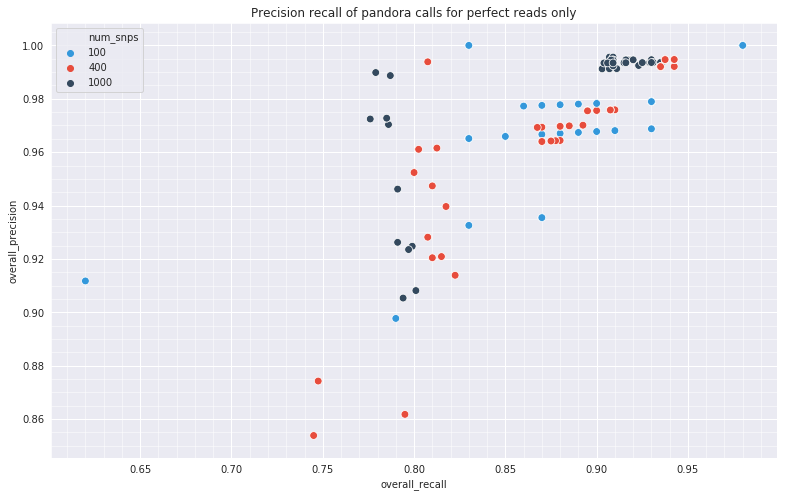

In [19]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP[:-1],
                       hue="num_snps", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

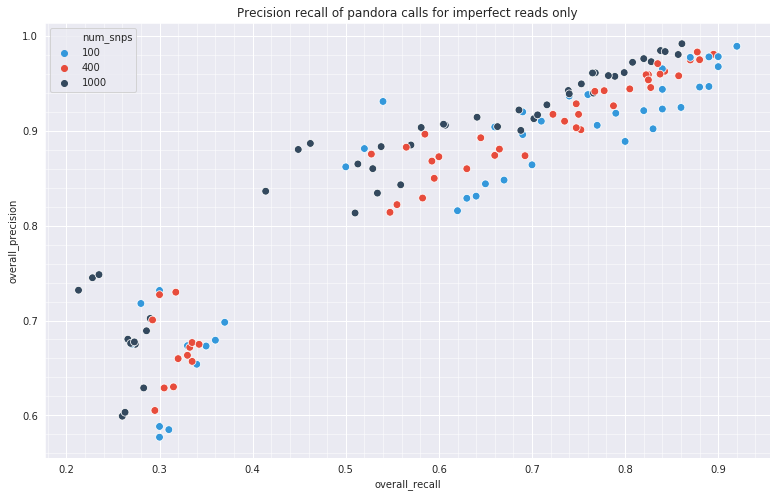

In [20]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP[:-1],
                       hue="num_snps", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

The effect of the number of SNPs per gene on the precision-recall relationship for `pandora` calls is quite interesting.  
For perfect reads, we see that the more SNPs per gene we have, the less variants we are able to call. Inversely, the more SNPs per gene we have the *more* variants we call correctly. There is a fairly distinct separation between the 10 SNP per gene samples and other groupings.  

For the imperfect reads we actually see a similar relationship than for the perfect reads. We do see a similar relationship with respect to precision (% of variants we call correct) albeit a fairly marginal difference between the number of SNPs per gene. And the recall (% variants we call) is greater the less SNPs per gene we have.  

Given that 10 SNPs per gene is a fairly extreme case (we would expect ~4 for *E. coli* and ~1 for MTB), the number of SNPs per gene doesn't seem to impact the ability of *de novo* discovery. 

## Effect of *de novo* k-mer size
After `pandora` has identified the slices in the graph which could be *de novo* mutations we build a de Bruijn graph from the reads mapping to these slices. Here we look at the effect of altering the k-mer size used for the de Bruijn graph.

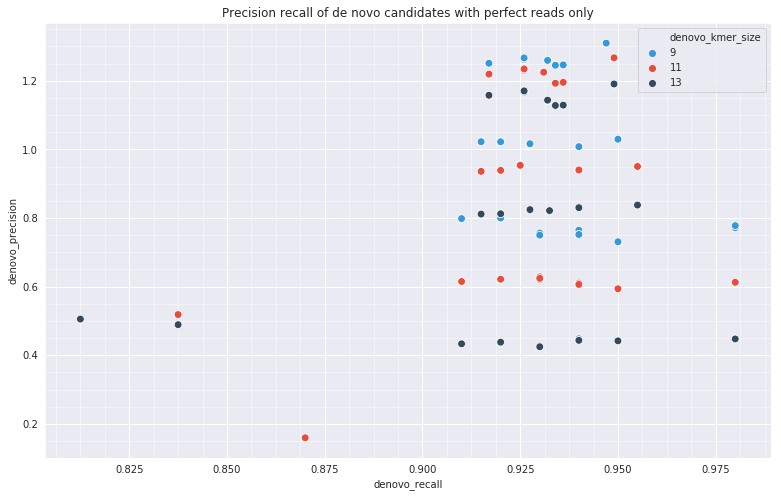

In [21]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP[:3], 
                       hue="denovo_kmer_size", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

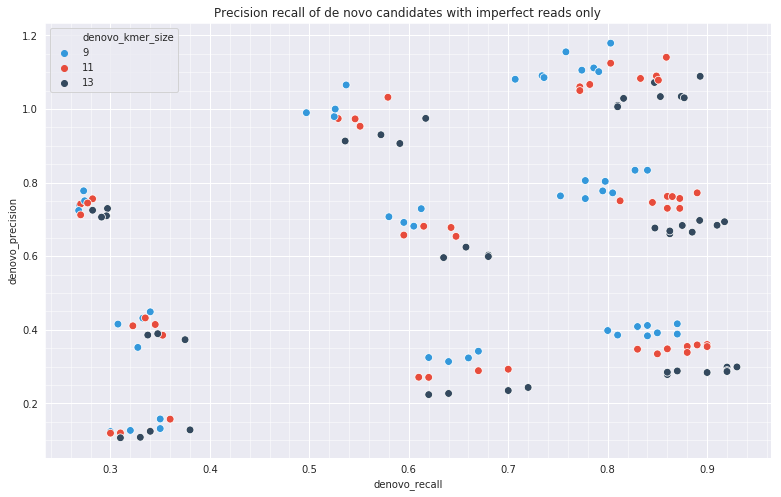

In [22]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP[:3], 
                       hue="denovo_kmer_size", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

These results suggest that the k-mer sizes used here do not differ from each other in their ability to discover *de novo* variants in the graph.

And now looking at the same thing from the VCF output of `pandora`

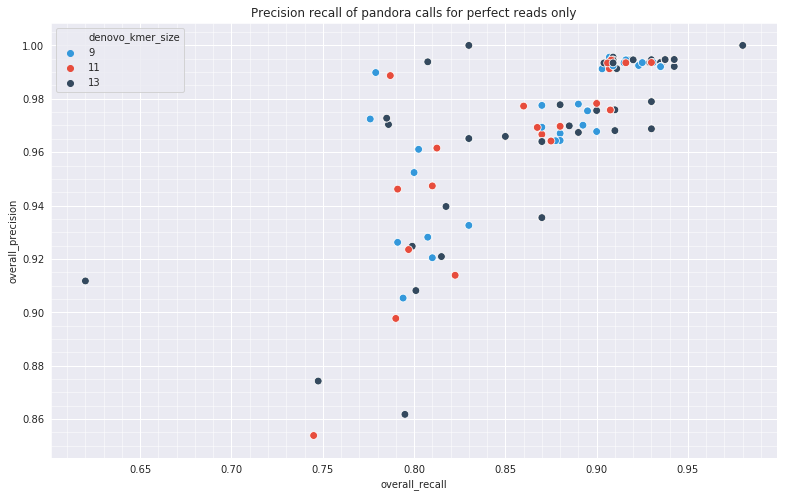

In [23]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP[:3],
                       hue="denovo_kmer_size", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

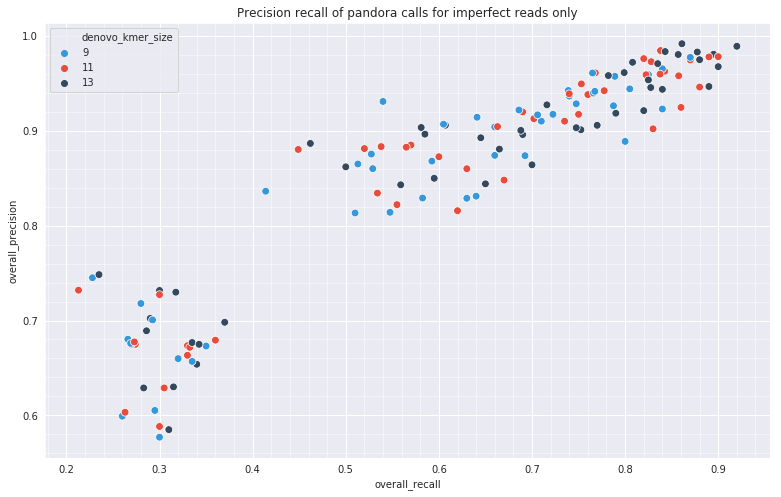

In [24]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP[:3], 
#                        style="coverage",
                       hue="denovo_kmer_size", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

The k-mer size using for *de novo* discovery does not appear to have a strong influence on the precision-recall relationship. There is perhaps a slight advangtage to using a *k* value of 11 or 13.  

In summary, the default *de novo* k-mer size of 11 is fine to stay as it is, but the use of 13 would unlikely make much difference to the results.

# Recall and error rate relationship
Here we will look at the parameter effects on the recall-error rate relationship.  

*Note:* The error rate here is defined as 1 - accuracy. In addition, as we are ignoring true negatives, this metric will look much higher than you would normally see as we are only looking at sites where we have added a variant, and not every site in the genome.

## Effect of coverage

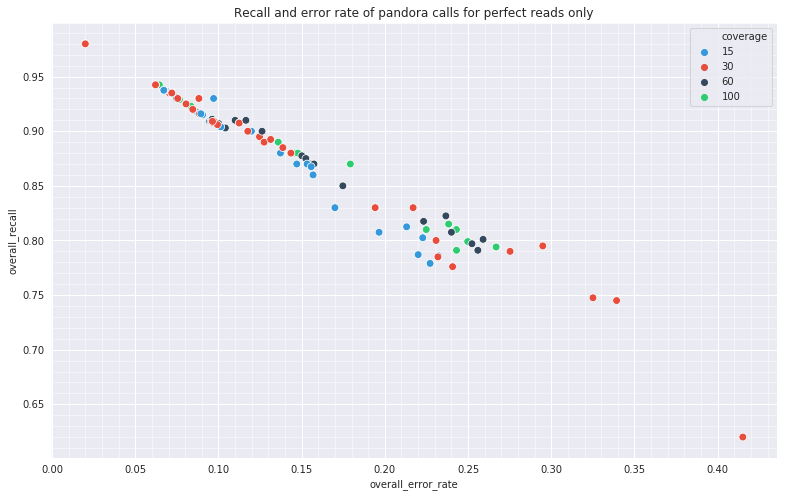

In [25]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="coverage", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

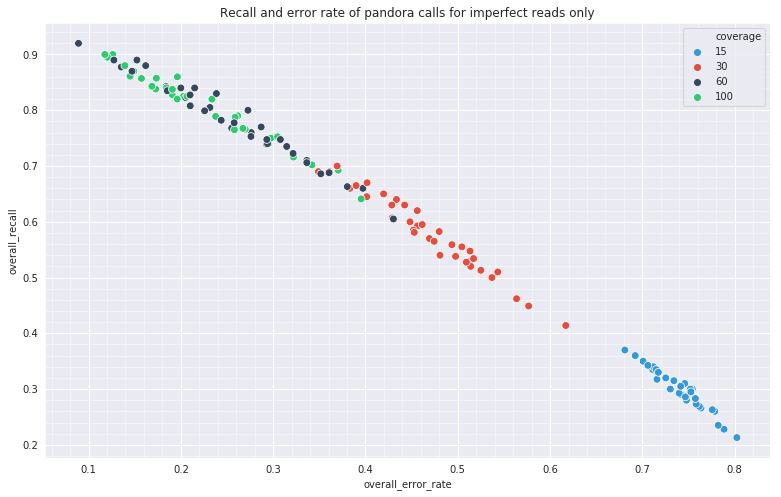

In [26]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="coverage", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

From this we can see that coverage again has an impact on the relationship.Once you get below 60x coverage the error rate increases quite a bit, although 30x isn't too bad.

## Effect of maximum nesting level

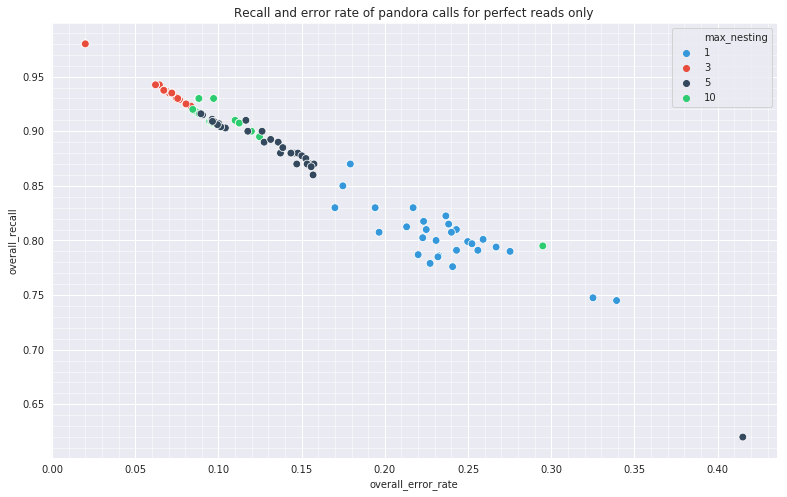

In [27]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="max_nesting",
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

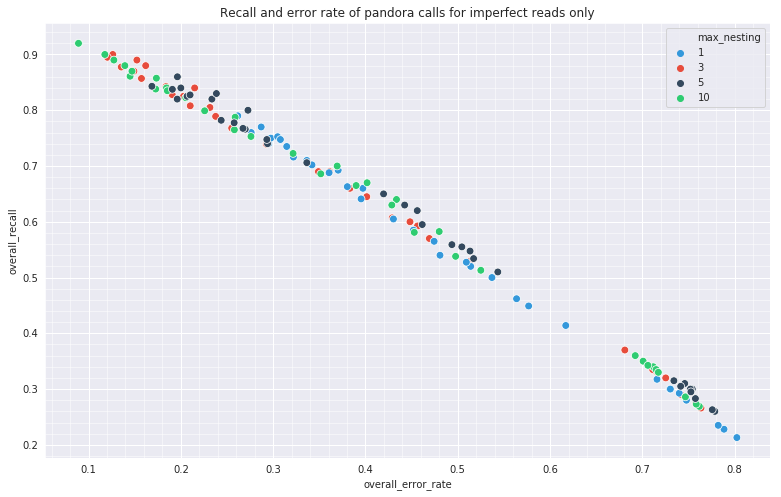

In [28]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="max_nesting", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

### These results are quite interesting in the fact that the perfect reads has a different relationship to the imperfect ones.  
In the perfect reads we see the different levels clustering together (which is actually based on the number of SNPs - see below). We do see that nesting levels of 3 and 5 give the lowest error rate and highest recall, on average.  

We do see the same overall result with the imperfect reads, however we do not see the same clustering based on the number of SNPs per gene (not shown). As with the precision-recall relationship, coverage is the parameter that is responsible for separating the groups. Within each coverage group though we still see maximum nesting level of 3 or 5 having the lower error rate and higher recall.  

As with precision-recall, a default value of 5 for maximum nesting seems the most appropriate.

## Effect of number of SNPs

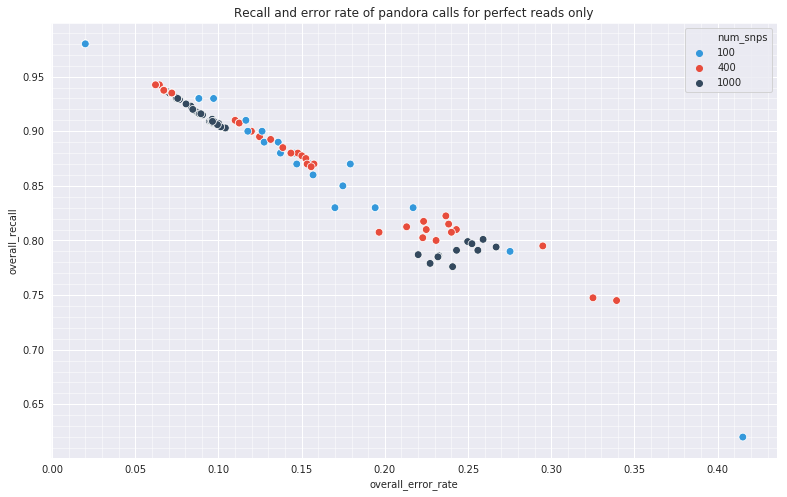

In [29]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP[:-1],
                       hue="num_snps",
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

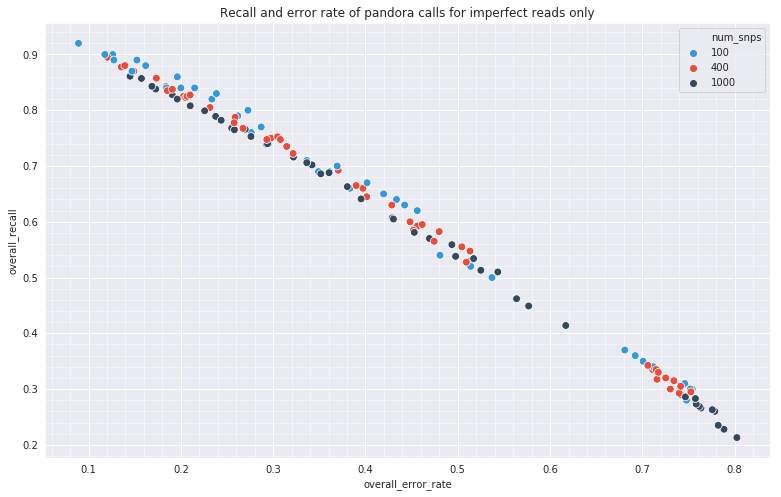

In [30]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP[:-1],
                       hue="num_snps",
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

As we saw in the precision-recall plots, number of SNPs per gene has some impact on the recall - the more SNPs we have per gene, the lower the recall.  

For perfect reads we certainly see a lower error rate with lower SNPs per gene.  
Imperfect reads have a similar relationship, but it is not as pronounced as with the perfect reads.

## Effect of *de novo* k-mer size

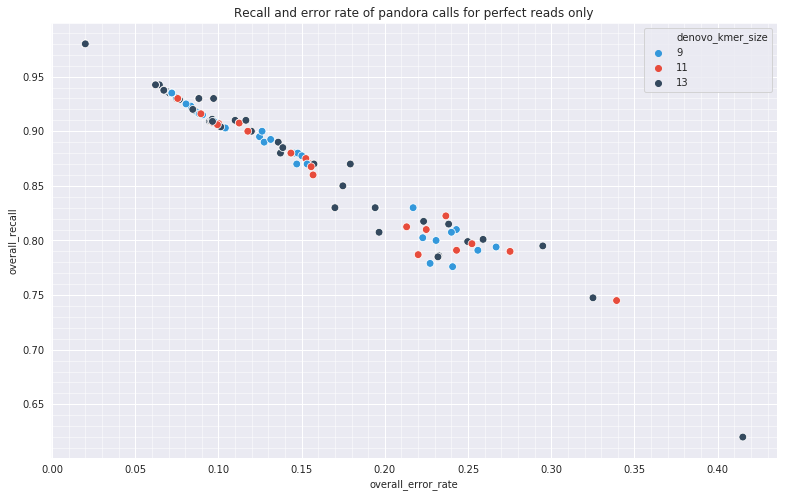

In [31]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP[:3],
                       hue="denovo_kmer_size",
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for perfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

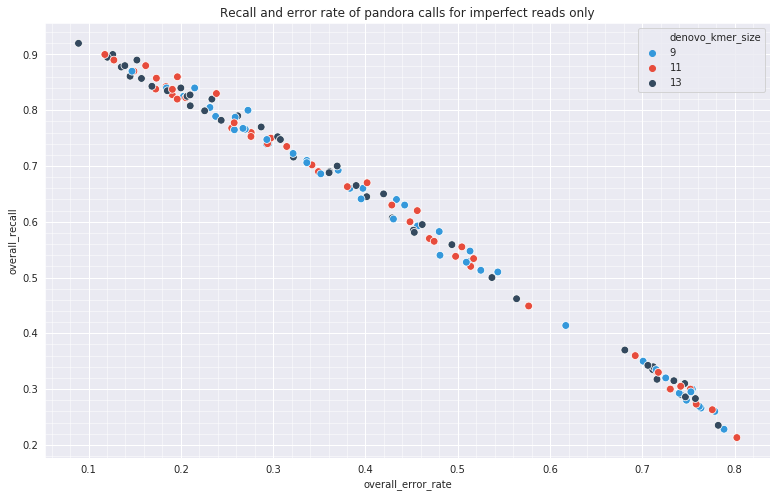

In [32]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP[:3],
                       hue="denovo_kmer_size", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Recall and error rate of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

As with the precision-recall relationship *de novo* k-mer size has a fairly small effect of the recall-error rate relationship. When breaking down in to coverage bands though, we again see that a value of 11 or 13 is likely the best.

## Compare no-*de novo* with *de novo*

In [39]:
results_no_denovo = [Result.from_json(p) for p in Path("../analysis/").rglob("*no_denovo/results.json")]

In [40]:
results_no_denovo_dicts = [r.as_dict() for r in results_no_denovo]
results_no_denovo_df = pd.DataFrame(results_no_denovo_dicts)

In [41]:
results_no_denovo_df

,conf_threshold,coverage,denovo_kmer_size,denovo_precision,denovo_recall,max_nesting,num_snps,overall_accuracy,overall_error_rate,overall_precision,overall_recall,read_quality
0,0,100,9,0.0,0.0,3,1000,0.007092,0.992908,0.032374,0.0090,imperfect
1,0,100,11,0.0,0.0,3,1000,0.007092,0.992908,0.032374,0.0090,imperfect
2,0,100,13,0.0,0.0,3,1000,0.007092,0.992908,0.032374,0.0090,imperfect
3,0,60,9,0.0,0.0,3,1000,0.007059,0.992941,0.031690,0.0090,imperfect
4,0,60,11,0.0,0.0,3,1000,0.007048,0.992952,0.031469,0.0090,imperfect
5,0,60,13,0.0,0.0,3,1000,0.007048,0.992952,0.031469,0.0090,imperfect
6,0,15,9,0.0,0.0,3,1000,0.007359,0.992641,0.038793,0.0090,imperfect
7,0,15,11,0.0,0.0,3,1000,0.007365,0.992635,0.038961,0.0090,imperfect
8,0,15,13,0.0,0.0,3,1000,0.007365,0.992635,0.038961,0.0090,imperfect
9,0,30,9,0.0,0.0,3,1000,0.007143,0.992857,0.033457,0.0090,imperfect


# Summary
Coverage is the factor which most impacts the precision-recall relationship. After this, the number of SNPs per gene also has some impact, but given the assumption we will be assessing bacterial with a 1-4 variants per gene this should not effect us.  

For further analysis, parameters will be set as such:  
- Number of SNPs per gene: 4
- Maximum nesting level: 5
- De novo kmer size: 11
- Coverage: ??

In [63]:
max_conf = 300
max_nesting = 10
denovo_kmer_size = 11
read_quality = "imperfect"
num_snps = 400
results_dicts_conf = []
for conf_threshold in range(0, max_conf):
    for r in results:
        if (r.denovo_kmer_size == denovo_kmer_size and 
            r.max_nesting == max_nesting and 
            r.read_quality == read_quality and 
            r.num_snps == num_snps):
            results_dicts_conf.append(r.as_dict(conf_threshold=conf_threshold))
df_with_denovo = pd.DataFrame(results_dicts_conf)
df_with_denovo["method"] = "with_denovo"
#df = conf_df.query("denovo_kmer_size==@denovo_kmer_size & num_snps==@num_snps & max_nesting==@max_nesting & read_quality==@read_quality")

In [64]:
results_no_denovo_dicts_conf = []
for conf_threshold in range(0, max_conf):
    for r in results_no_denovo:
        if (r.denovo_kmer_size == denovo_kmer_size and 
                r.max_nesting == max_nesting and 
                r.read_quality == read_quality and 
                r.num_snps == num_snps):
            results_no_denovo_dicts_conf.append(r.as_dict(conf_threshold=conf_threshold))
df_no_denovo = pd.DataFrame(results_no_denovo_dicts_conf)
df_no_denovo["method"] = "no_denovo"

In [65]:
df = pd.concat([df_with_denovo, df_no_denovo])
df = df.reset_index()
df

,index,conf_threshold,coverage,denovo_kmer_size,denovo_precision,denovo_recall,max_nesting,num_snps,overall_accuracy,overall_error_rate,overall_precision,overall_recall,read_quality,method
0,0,0,100,11,0.757050,0.8725,10,400,0.826506,0.173494,0.958101,0.8575,imperfect,with_denovo
1,1,0,60,11,0.746137,0.8450,10,400,0.794686,0.205314,0.959184,0.8225,imperfect,with_denovo
2,2,0,15,11,0.432258,0.3350,10,400,0.282655,0.717345,0.663317,0.3300,imperfect,with_denovo
3,3,0,30,11,0.678100,0.6425,10,400,0.571429,0.428571,0.860068,0.6300,imperfect,with_denovo
4,4,1,100,11,0.757050,0.8725,10,400,0.826506,0.173494,0.958101,0.8575,imperfect,with_denovo
5,5,1,60,11,0.746137,0.8450,10,400,0.794686,0.205314,0.959184,0.8225,imperfect,with_denovo
6,6,1,15,11,0.432258,0.3350,10,400,0.282655,0.717345,0.663317,0.3300,imperfect,with_denovo
7,7,1,30,11,0.678100,0.6425,10,400,0.571429,0.428571,0.860068,0.6300,imperfect,with_denovo
8,8,2,100,11,0.757050,0.8725,10,400,0.826506,0.173494,0.958101,0.8575,imperfect,with_denovo
9,9,2,60,11,0.746137,0.8450,10,400,0.794686,0.205314,0.959184,0.8225,imperfect,with_denovo


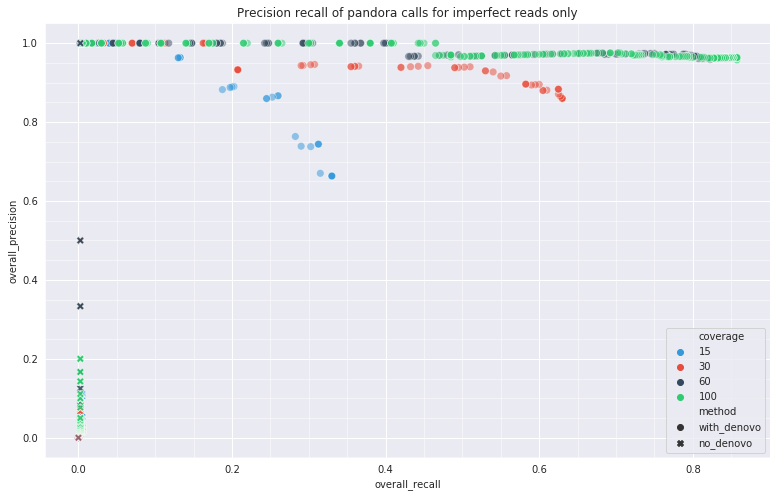

In [71]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=df, 
                       ax=ax, 
                       palette=CMAP, alpha=0.5,
                       hue="coverage", 
                       style="method",
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

[(0.95, 1.01)]

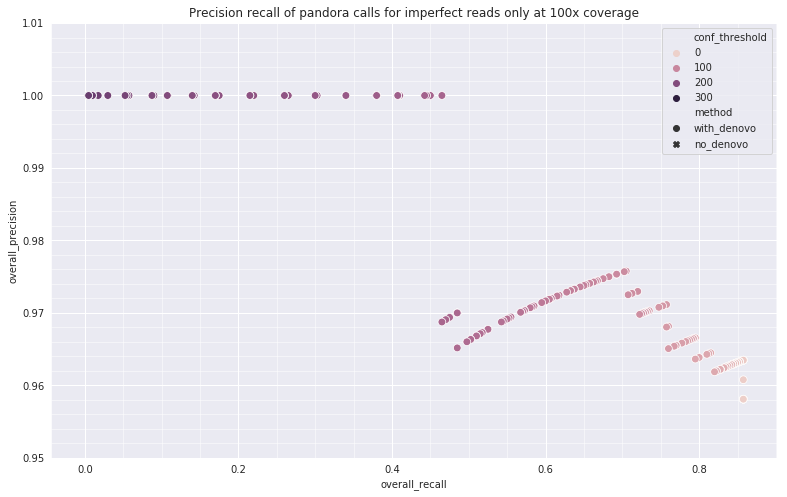

In [72]:
zam_df = df[df["coverage"] == 100]
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=zam_df, 
                       ax=ax,
                       style="method",
                       hue="conf_threshold",  
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only at 100x coverage")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
plot.set(ylim=(.95, 1.01))

The record with the maximum precision value for the no-*de novo* data.

In [74]:
df_no_denovo.loc[df_no_denovo["overall_precision"].idxmax()]

conf_threshold              124
coverage                     60
denovo_kmer_size             11
denovo_precision              0
denovo_recall                 0
max_nesting                  10
num_snps                    400
overall_accuracy         0.0025
overall_error_rate       0.9975
overall_precision             1
overall_recall           0.0025
read_quality          imperfect
method                no_denovo
Name: 497, dtype: object

The record with the maximum recall value for the no-*de novo* data.

In [75]:
df_no_denovo.loc[df_no_denovo["overall_recall"].idxmax()]

conf_threshold                 0
coverage                     100
denovo_kmer_size              11
denovo_precision               0
denovo_recall                  0
max_nesting                   10
num_snps                     400
overall_accuracy      0.00379507
overall_error_rate      0.996205
overall_precision      0.0155039
overall_recall             0.005
read_quality           imperfect
method                 no_denovo
Name: 0, dtype: object

## Investigating loss of recall

In this first step we look at whether all of the simulated genes are present in the consesnsus sequence. If there are genes missing, we need to figure out whether these genes contained SNPs. If so, these SNPs are an easy way to explain part of the recall loss. So the question we are asking here is:  
**How much recall do we lose from genes missed?**

In [36]:
import pysam
import numpy as np
import itertools
from pathlib import Path
from typing import Tuple
NUM_SNPS = 400
MAX_NESTING = 5
READ_QUALITY = "imperfect"
DENOVO_K = 11

In [37]:
prg_file = Path(f"../data/prgs/max_nesting_lvl_{MAX_NESTING}/combined.prg.fa")
assert prg_file.is_file()
stats = dict()

The first step is figuring out how many genes were found in the consensus sequence.

In [38]:
consensus_sequences = list(Path().glob(f"../analysis/{MAX_NESTING}/{NUM_SNPS}/{READ_QUALITY}/*/{DENOVO_K}/map_without_discovery/pandora.consensus.fq.gz"))

In [39]:
genes_in_prg = set()
with pysam.FastxFile(prg_file) as fh:
    for record in fh:
        genes_in_prg.add(record.name)
num_genes_in_prg = len(genes_in_prg)

In [40]:
genes_in_consensus = dict()
for consensus in consensus_sequences:
    covg = consensus.parts[5]
    genes = set()
    with pysam.FastxFile(consensus) as fh:
        for record in fh:
            genes.add(record.name)
    genes_in_consensus[covg] = genes
    stats[covg] = {"num_genes_in_consensus": len(genes)}
    print(f"{len(genes)} / {num_genes_in_prg} genes found for {covg}x coverage")

93 / 100 genes found for 100x coverage
93 / 100 genes found for 60x coverage
96 / 100 genes found for 15x coverage
91 / 100 genes found for 30x coverage


*Observation: it is strange that 15x (lowest coverage) discovers more genes than the other coverages.*

Now to determine which genes are not present in the consensus sequence.

In [41]:
genes_not_present_in_consensus = dict()
for covg, genes_present in genes_in_consensus.items():
    genes_not_present_in_consensus[covg] = genes_in_prg - genes_present
    stats[covg]["num_absent_genes"] = len(genes_in_prg - genes_present)

In [42]:
genes_not_present_in_consensus

{'100': {'GC00000073_12',
  'GC00000109_11',
  'GC00000119_18',
  'GC00000489_1',
  'GC00000536_r1_1',
  'GC00001527_3',
  'GC00011888'},
 '60': {'GC00000073_12',
  'GC00000109_11',
  'GC00000119_18',
  'GC00000489_1',
  'GC00000536_r1_1',
  'GC00001527_3',
  'GC00011888'},
 '15': {'GC00000073_12', 'GC00000536_r1_1', 'GC00001527_3', 'GC00011888'},
 '30': {'GC00000010_6',
  'GC00000073_12',
  'GC00000109_11',
  'GC00000119_18',
  'GC00000472_1',
  'GC00000489_1',
  'GC00000536_r1_1',
  'GC00001527_3',
  'GC00011888'}}

For the next step, we need to get the gene coordinates for the introduced SNPs. To introduce the SNPs, a random path was selected from the PRG for each gene and then all these random paths were concatenated into a single linear sequence. Then SNPs were introduced on this. As the ordering of genes on this linear sequence is not stored anywhere I need to find each gene's coordinates in this linear sequence, and then convert the index of a SNP on the linear sequence to a coordinate on the gene sequence.

In [43]:
def get_indices_of_gene_in_ref(ref: str, gene: str) -> Tuple[int, int]:
    """Returns the start and end indixes of gene in ref. The indices are returned in the 
    form [start, end] that is, start and end are inclusive."""
    start = ref.index(gene)
    end = start + len(gene) - 1
    return start, end
#test
assert get_indices_of_gene_in_ref("AAAFOOAAAA", "FOO") == (3, 5)
assert get_indices_of_gene_in_ref("AAAFOO", "FOO") == (3, 5)
assert get_indices_of_gene_in_ref("FOOAAA", "FOO") == (0, 2)

In [44]:
combined_random_paths = Path(f"../analysis/{MAX_NESTING}/combined_random_paths.fa")
individual_random_paths = Path(f"../analysis/{MAX_NESTING}/random_paths.fa")
vcf_of_introduced_snps = Path(f"../analysis/{MAX_NESTING}/{NUM_SNPS}/combined_random_paths_mutated.vcf")

In [45]:
with pysam.FastxFile(combined_random_paths) as fh:
    linear_sequence = next(fh).sequence

While we're at it, lets take a quick look at how long each of the absent genes is.

In [46]:
absent_genes = set.union(*genes_not_present_in_consensus.values())

In [47]:
gene_coordinates_on_ref = dict()
with pysam.FastxFile(individual_random_paths) as fh:
    for record in fh:
        name = record.name[:-2] # the seq name has had an _0 added to the end
        idx = get_indices_of_gene_in_ref(linear_sequence, record.sequence)
        assert idx not in gene_coordinates_on_ref
        gene_coordinates_on_ref[idx] = name
        if name in absent_genes:
            print(f"{name}\t{len(record.sequence)}bp")
assert len(gene_coordinates_on_ref) == len(genes_in_prg)

GC00000119_18	120bp
GC00000472_1	150bp
GC00000073_12	96bp
GC00000489_1	159bp
GC00011888	186bp
GC00000010_6	192bp
GC00000536_r1_1	177bp
GC00000109_11	195bp
GC00001527_3	180bp


In [48]:
snp_positions = []
with pysam.VariantFile(vcf_of_introduced_snps) as vcf:
    for entry in vcf:
        snp_positions.append(entry.pos-1)
snp_positions = np.array(sorted(snp_positions))
assert len(snp_positions) == NUM_SNPS

In [49]:
gene_snp_coordinates = dict()
for (start, end), gene_name in gene_coordinates_on_ref.items():
    start_idx = np.searchsorted(snp_positions, start, 'left')
    end_idx = np.searchsorted(snp_positions, end, 'right')
    snp_positions_in_gene = np.arange(start_idx, end_idx).tolist()
    positions_in_linear = []
    positions_in_gene = []
    for i in snp_positions_in_gene:
        pos = snp_positions[i]
        positions_in_linear.append(pos)
        positions_in_gene.append(pos - start)
    gene_snp_coordinates[gene_name] = {"positions_in_linear": positions_in_linear, 
                                      "positions_in_gene": positions_in_gene,
                                      "gene_length": end-start}
    

total = 0
for d in gene_snp_coordinates.values():
    total += len(d["positions_in_gene"])
assert total == NUM_SNPS

In [50]:
for covg, genes in genes_in_consensus.items():
    num_snps_on_absent_genes = 0
    genes_missing_for_covg = genes_in_prg - set(genes)
    for gene in genes_missing_for_covg:
        if gene in absent_genes:
            num_snps_on_absent_genes += len(gene_snp_coordinates[gene]["positions_in_linear"])
    stats[covg]["num_snps_on_absent_genes"] = num_snps_on_absent_genes
        
    print(f"{covg}x: There are {num_snps_on_absent_genes} / 400 SNPs ({round(num_snps_on_absent_genes/400*100, 2)}%) on {len(genes_missing_for_covg)} missing genes.")

100x: There are 14 / 400 SNPs (3.5%) on 7 missing genes.
60x: There are 14 / 400 SNPs (3.5%) on 7 missing genes.
15x: There are 7 / 400 SNPs (1.75%) on 4 missing genes.
30x: There are 14 / 400 SNPs (3.5%) on 9 missing genes.


Now let's see how many present SNPs are within twice the denovo kmer size of the start and end of the gene it is in. Due to the way denovo discovery works, we cannot find SNPs within ($2*k$)-bases of the start and end of the gene.

In [51]:
for covg, genes in genes_in_consensus.items():
    num_near_ends = []
    for gene in genes:
        length = gene_snp_coordinates[gene]["gene_length"]
        for pos in gene_snp_coordinates[gene]["positions_in_gene"]: 
            is_near_end = True if (pos < (DENOVO_K*2)) or (pos >= (length-DENOVO_K*2)) else False
            num_near_ends.append(is_near_end)
            
    assert len(num_near_ends) == (NUM_SNPS - stats[covg]["num_snps_on_absent_genes"])
    stats[covg]["num_snps_near_ends"] = sum(num_near_ends)
    print(f"{covg}x:\t{stats[covg]['num_snps_near_ends']} / {NUM_SNPS} SNPs ({round(stats[covg]['num_snps_near_ends']/NUM_SNPS*100, 2)}%) are within {2*DENOVO_K} bases of the ends.")

100x:	18 / 400 SNPs (4.5%) are within 22 bases of the ends.
60x:	18 / 400 SNPs (4.5%) are within 22 bases of the ends.
15x:	21 / 400 SNPs (5.25%) are within 22 bases of the ends.
30x:	18 / 400 SNPs (4.5%) are within 22 bases of the ends.


So to summarise how many SNPs are missing due to both missing genes and being near the ends of genes.

In [52]:
for covg, d in stats.items():
    total_missing = d["num_snps_near_ends"] + d["num_snps_on_absent_genes"]
    print(f"{covg}x:\t{total_missing} / {NUM_SNPS} of SNPs ({round(total_missing/NUM_SNPS*100, 2)}%) are not currently discoverable.")

100x:	32 / 400 of SNPs (8.0%) are not currently discoverable.
60x:	32 / 400 of SNPs (8.0%) are not currently discoverable.
15x:	28 / 400 of SNPs (7.0%) are not currently discoverable.
30x:	32 / 400 of SNPs (8.0%) are not currently discoverable.


Looking at how many false negatives we had.

Load the result json files into a custom class that gives easy access to evaluation metrics.

In [53]:
for r in results:
    if (r.denovo_kmer_size == denovo_kmer_size and 
            r.max_nesting == max_nesting and 
            r.read_quality == read_quality and 
            r.num_snps == num_snps):
        fns = r.overall_false_negatives()
        undiscoverable = stats[str(r.coverage)]["num_snps_near_ends"] + stats[str(r.coverage)]["num_snps_on_absent_genes"]
        print(f"{r.coverage}x:\t{undiscoverable}/{fns} false negatives ({round(undiscoverable/fns*100, 2)}%) are undiscoverable.")

100x:	32/57 false negatives (56.14%) are undiscoverable.
60x:	32/71 false negatives (45.07%) are undiscoverable.
15x:	28/268 false negatives (10.45%) are undiscoverable.
30x:	32/148 false negatives (21.62%) are undiscoverable.
